In [1]:
RANDOM_STATE = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import joblib
import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
)

pd.set_option("display.max_columns", None)

print("OK imports.")
shap.initjs()


OK imports.


In [2]:
# Cellule 2 — Chargement du CSV + définition des features (identique au script d’entraînement)

# Chargement des données
df = pd.read_csv("nhanes_ready.csv")
print(df.shape)
display(df.head(3))

# Cible
target = "diabetes"
assert target in df.columns, "Colonne 'diabetes' absente du CSV."
print(df[target].value_counts(dropna=False))
print((df[target].value_counts(normalize=True)*100).round(2))

# Même logique de features que dans le script du modèle
USE_ETHNICITY = True

core = ["RIDAGEYR", "RIAGENDR", "smoker"]
morpho = ["BMXBMI_log", "BMXWAIST"]
lifestyle = ["PAD680_log", "SLD012"]
ethn = [
    "ethnicity_MexicanAmerican", "ethnicity_OtherHispanic",
    "ethnicity_NonHispanicWhite", "ethnicity_NonHispanicBlack",
    "ethnicity_NonHispanicAsian", "ethnicity_OtherRace"
]

if USE_ETHNICITY:
    candidate_feats = core + morpho + lifestyle + ethn
else:
    candidate_feats = core + morpho + lifestyle 

features = [c for c in candidate_feats if c in df.columns]
missing = [c for c in candidate_feats if c not in df.columns]
if missing:
    print("Colonnes absentes (ignorées) :", missing)

X_full = df[features].copy()
y = df[target].astype(int)

print(f"X_full : {X_full.shape} | y pos rate : {y.mean():.3f}")
features


(6889, 38)


,SEQN,RIDAGEYR,RIAGENDR,LBXTC,BMXHT,BMXBMI,BMXWT,BMXWAIST,BMXARMC,PAD680,SLD012,DRKCAL,DRPROT,DRSUGR,DRFIBE,DRTFAT,DRTALCO,DRCARB,DRWATER,smoker,diabetes,PAD680_log,DRTALCO_log,DRWATER_log,DRSUGR_log,DRFIBE_log,DRCARB_log,DRPROT_log,DRTFAT_log,DRKCAL_log,BMXBMI_log,ethnicity_MexicanAmerican,ethnicity_NonHispanicAsian,ethnicity_NonHispanicBlack,ethnicity_NonHispanicWhite,ethnicity_OtherHispanic,ethnicity_OtherRace,chol_high
0,130378.0,43.0,1,264.0,179.5,27.0,86.9,98.3,35.7,360.0,9.5,1390.0,88.525,22.060,5.95,47.420,2.280000e+01,109.785,1020.0,1,0,5.888878,3.169686e+00,6.928538,3.138100,1.938742,4.707591,4.494518,3.879913,7.237778,3.332205,False,True,False,False,False,False,1
1,130379.0,66.0,1,214.0,174.2,33.5,101.8,114.7,33.7,480.0,9.0,2484.5,82.620,113.495,24.15,73.190,6.030000e+01,280.440,120.0,1,0,6.175867,4.115780e+00,4.795791,4.740531,3.224858,5.639919,4.426283,4.306629,7.818229,3.540959,False,False,False,True,False,False,0
2,130380.0,44.0,2,187.0,152.9,29.7,69.4,93.5,36.3,240.0,8.0,1735.0,67.115,110.920,21.40,55.685,5.397605e-79,245.325,1747.5,0,1,5.484797,5.397605e-79,7.466514,4.717784,3.109061,5.506652,4.221197,4.037510,7.459339,3.424263,False,False,False,False,True,False,0


diabetes
0    6115
1     774
Name: count, dtype: int64
diabetes
0    88.76
1    11.24
Name: proportion, dtype: float64
X_full : (6889, 13) | y pos rate : 0.112


['RIDAGEYR',
 'RIAGENDR',
 'smoker',
 'BMXBMI_log',
 'BMXWAIST',
 'PAD680_log',
 'SLD012',
 'ethnicity_MexicanAmerican',
 'ethnicity_OtherHispanic',
 'ethnicity_NonHispanicWhite',
 'ethnicity_NonHispanicBlack',
 'ethnicity_NonHispanicAsian',
 'ethnicity_OtherRace']

In [3]:
# Cellule 3 — Recréation du split train / val / test (même que pour le modèle)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=RANDOM_STATE
)

print("=== Répartition ===")
print(f"Train : {len(X_train)} | Val : {len(X_val)} | Test : {len(X_test)}")
print("Taux pos — Train/Val/Test :", round(y_train.mean(),3), round(y_val.mean(),3), round(y_test.mean(),3))


=== Répartition ===
Train : 4133 | Val : 1378 | Test : 1378
Taux pos — Train/Val/Test : 0.112 0.112 0.112


In [4]:
# Cellule 4 — Colonnes numériques / binaires + chargement du scaler

# Colonnes binaires (non standardisées)
binary_cols = ["RIAGENDR", "smoker"]
if USE_ETHNICITY:
    binary_cols += [
        "ethnicity_MexicanAmerican", "ethnicity_OtherHispanic",
        "ethnicity_NonHispanicWhite", "ethnicity_NonHispanicBlack",
        "ethnicity_NonHispanicAsian", "ethnicity_OtherRace"
    ]
binary_cols = [c for c in binary_cols if c in X_train.columns]

# Colonnes numériques (standardisées)
num_cols = [c for c in X_train.columns if c not in binary_cols]
print(f"Colonnes standardisées ({len(num_cols)}) : {num_cols}")

# Chargement du scaler déjà appris
ART = Path("artifacts_diab_no_bias")
scaler = joblib.load(ART / "scaler_diab_no_bias.pkl")
print("Scaler chargé :", ART / "scaler_diab_no_bias.pkl")

# Application du scaler aux splits
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

print("Standardisation appliquée.")


Colonnes standardisées (5) : ['RIDAGEYR', 'BMXBMI_log', 'BMXWAIST', 'PAD680_log', 'SLD012']
Scaler chargé : artifacts_diab_no_bias\scaler_diab_no_bias.pkl
Standardisation appliquée.


In [5]:
# Cellule 5 — Chargement du modèle et vérification rapide sur le test

lgb_tuned = joblib.load(ART / "model_lightgbm_diab_no_bias.pkl")
print("Modèle chargé :", ART / "model_lightgbm_diab_no_bias.pkl")

# Probas & métriques de base
y_test_proba = lgb_tuned.predict_proba(X_test)[:, 1]
y_test_pred_05 = (y_test_proba >= 0.5).astype(int)

print("=== RAPPORT DE CLASSIFICATION (TEST, seuil 0.5) ===")
print(classification_report(y_test, y_test_pred_05, digits=3))
print(f"ROC AUC (test) : {roc_auc_score(y_test, y_test_proba):.4f}")


Modèle chargé : artifacts_diab_no_bias\model_lightgbm_diab_no_bias.pkl
=== RAPPORT DE CLASSIFICATION (TEST, seuil 0.5) ===
              precision    recall  f1-score   support

           0      0.968     0.702     0.814      1223
           1      0.258     0.819     0.393       155

    accuracy                          0.715      1378
   macro avg      0.613     0.760     0.603      1378
weighted avg      0.889     0.715     0.766      1378

ROC AUC (test) : 0.8312


In [6]:
# Cellule 6 : Préparation des données pour SHAP (background & dataset à expliquer)

# Le background = toute la partie train (représentation de la population "normale")
X_background = X_train.copy()

# On explique tout le test (small dataset = OK)
X_test_sample = X_test.copy()

print("Background :", X_background.shape)
print("Test sample :", X_test_sample.shape)


Background : (4133, 13)
Test sample : (1378, 13)


In [7]:
#  Cellule 7 — Calcul des valeurs SHAP (Nouvelle API SHAP)

# Explainer moderne SHAP pour LightGBM
explainer = shap.TreeExplainer(lgb_tuned)

# Utilisation de l'API moderne : explainer(X)
shap_output = explainer(X_test_sample)

# shap_output.values = matrice SHAP (n_samples, n_features)
shap_values_pos = shap_output.values

# Valorisation de base (moyenne de prédiction sur background)
base_value = shap_output.base_values

print("SHAP values matrix shape :", shap_values_pos.shape)
print("Base value shape :", base_value.shape)


SHAP values matrix shape : (1378, 13)
Base value shape : (1378,)


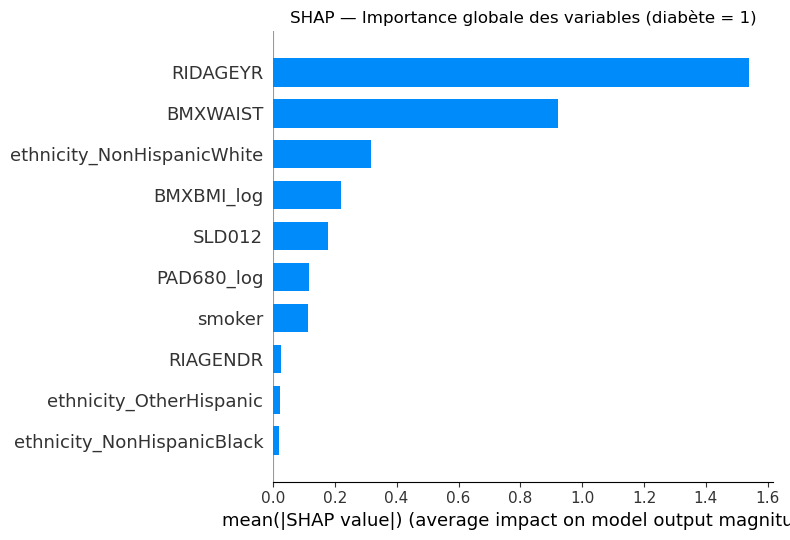

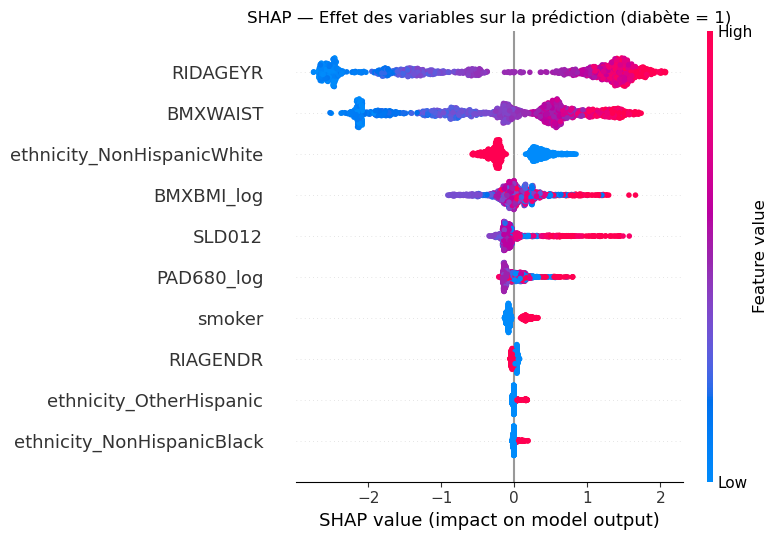

In [8]:
#  Cellule 8 — Visualisation globale SHAP (summary plots)

# 1) Bar plot : importance moyenne absolue des variables
plt.figure()
shap.summary_plot(
    shap_values_pos,
    X_test_sample,
    plot_type="bar",
    max_display=10,
    show=False
)
plt.title("SHAP — Importance globale des variables (diabète = 1)")
plt.tight_layout()
plt.show()

# 2) Beeswarm : direction + intensité des effets
plt.figure()
shap.summary_plot(
    shap_values_pos,
    X_test_sample,
    max_display=10,
    show=False
)
plt.title("SHAP — Effet des variables sur la prédiction (diabète = 1)")
plt.tight_layout()
plt.show()


In [9]:
#Le modèle LightGBM identifie l’âge et le tour de taille comme les prédicteurs dominants du diabète, 
#suivis d’un effet modéré de l’ethnie et de plusieurs variables nutritionnelles (alcool, sucres, fibres). 
#Les comportements (smoking) et le sommeil jouent un rôle marginal.